In [4]:
#Predict customers' credit future spend on card, based on historical spend data and demographic parameters

# Understanding the consumption pattern for credit cards at an individual consumer level is important for customer relationship management. This understanding allows banks to customize for consumers and make strategic marketing plans. Thus it is imperative to study the relationship between the characteristics of the consumers and their consumption patterns. Bank of Trust has given a sample of their customers, along with their details like age, gender and other demographics. Bank of Trust has also shared information on liabilities, assets and history of transactions with the bank for each customer. In addition to the above, data has been provided for a particular set of customers' credit card spend in the previous 3 months (April, May & June) and their expected average spend in the coming 3 months (July, August & September). The goal is to predict the average spend for the customers for the upcoming 3 months.

Epoch 20/100 - Train Loss: 0.9677, Test Loss: 1.0243
Epoch 40/100 - Train Loss: 0.9012, Test Loss: 1.0382
Epoch 60/100 - Train Loss: 0.8138, Test Loss: 1.0593
Epoch 80/100 - Train Loss: 0.6878, Test Loss: 1.1067
Epoch 100/100 - Train Loss: 0.5314, Test Loss: 1.2067

Sample Predictions vs Actual:
Predicted: 29958.55, Actual: 20111.24
Predicted: 25420.74, Actual: 32704.96
Predicted: 12981.95, Actual: 14158.98
Predicted: 19249.49, Actual: 20237.11
Predicted: 17765.62, Actual: 18754.50


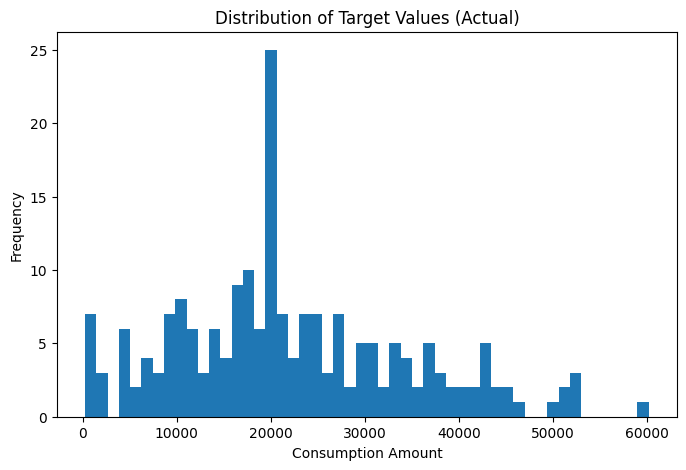

In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# ===================== LOAD DATA =====================
df = pd.read_csv("synthetic_bank_data.csv")  # <-- Use the generated dataset

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical features
for col in ['account_type', 'gender']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# ===================== FEATURES & TARGET =====================
target = 'cc_cons_apr'  # Predicting April credit card consumption
X = df.drop(columns=['id', target])
y = df[target]

# ===================== SPLIT & SCALE =====================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# ===================== MODEL =====================
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Net(X_train_tensor.shape[1])

# ===================== TRAINING =====================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        model.eval()
        test_loss = criterion(model(X_test_tensor), y_test_tensor).item()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

# ===================== PREDICTIONS =====================
model.eval()
y_pred_scaled = model(X_test_tensor).detach().numpy()
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test_tensor)

print("\nSample Predictions vs Actual:")
for i in range(5):
    print(f"Predicted: {y_pred[i][0]:.2f}, Actual: {y_test_rescaled[i][0]:.2f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(8,5))
plt.hist(y_test_rescaled, bins=50)
plt.title('Distribution of Target Values (Actual)')
plt.xlabel('Consumption Amount')
plt.ylabel('Frequency')
plt.show()


In [37]:
# define a custom root mean square logarithmic error function
def rmsle(y_pred, y_true):

  # ensure that predictions are positive + 1 to avoid log(0)
  y_pred=torch.clamp(y_pred,min=0)+1
  y_true=torch.clamp(y_true, min=0)+1

  # calculate the logarithms and comput the squared difference
  log_pred=torch.log(y_pred)
  log_true=torch.log(y_true)
  squared_log_error=(log_pred-log_true)**2

  # compute mean of squared log error and take the square root
  mean_squared_log_error=torch.mean(squared_log_error)
  rmsle=torch.sqrt(mean_squared_log_error)

  return rmsle

In [38]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim


In [41]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [42]:
train_data=TensorDataset(X_train_tensor, y_train_tensor)

In [51]:
# Use Adam with a slightly higher LR
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss lists
train_loss_list = []
test_loss_list = []
num_epochs = 400
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        pred = model(X_batch)
        loss = rmsle(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute losses on full train/test sets
    model.eval()
    with torch.no_grad():
        train_loss = rmsle(model(X_train_tensor), y_train_tensor).item()
        test_loss = rmsle(model(X_test_tensor), y_test_tensor).item()
    model.train()

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    # Print every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 20/400 - Train Loss: 0.0742, Test Loss: 0.4628
Epoch 40/400 - Train Loss: 0.0581, Test Loss: 0.4565
Epoch 60/400 - Train Loss: 0.0481, Test Loss: 0.4580
Epoch 80/400 - Train Loss: 0.0507, Test Loss: 0.4532
Epoch 100/400 - Train Loss: 0.0453, Test Loss: 0.4541
Epoch 120/400 - Train Loss: 0.0417, Test Loss: 0.4523
Epoch 140/400 - Train Loss: 0.0420, Test Loss: 0.4577
Epoch 160/400 - Train Loss: 0.0442, Test Loss: 0.4602
Epoch 180/400 - Train Loss: 0.0378, Test Loss: 0.4553
Epoch 200/400 - Train Loss: 0.0379, Test Loss: 0.4592
Epoch 220/400 - Train Loss: 0.0387, Test Loss: 0.4570
Epoch 240/400 - Train Loss: 0.0377, Test Loss: 0.4569
Epoch 260/400 - Train Loss: 0.0355, Test Loss: 0.4613
Epoch 280/400 - Train Loss: 0.0380, Test Loss: 0.4653
Epoch 300/400 - Train Loss: 0.0347, Test Loss: 0.4579
Epoch 320/400 - Train Loss: 0.0352, Test Loss: 0.4546
Epoch 340/400 - Train Loss: 0.0377, Test Loss: 0.4624
Epoch 360/400 - Train Loss: 0.0344, Test Loss: 0.4608
Epoch 380/400 - Train Loss: 0.03

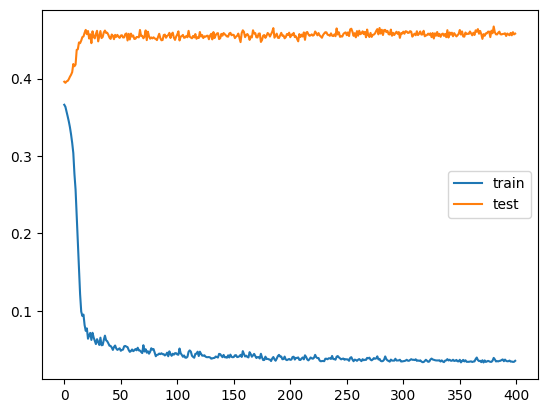

In [52]:
plt.plot(range(num_epochs),train_loss_list,label='train')
plt.plot(range(num_epochs),test_loss_list,label='test')
plt.legend()
plt.show()


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [58]:
# Use Adam with a slightly higher LR
model = Net()
optimizer = optim.Adam(model.parameters(),lr=0.0000000001)

# Loss lists
train_loss_list = []
test_loss_list = []
num_epochs = 400
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        pred = model(X_batch)
        loss = rmsle(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute losses on full train/test sets
    model.eval()
    with torch.no_grad():
        train_loss = rmsle(model(X_train_tensor), y_train_tensor).item()
        test_loss = rmsle(model(X_test_tensor), y_test_tensor).item()

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    # Print every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 20/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 40/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 60/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 80/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 100/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 120/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 140/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 160/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 180/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 200/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 220/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 240/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 260/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 280/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 300/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 320/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 340/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 360/400 - Train Loss: 0.4480, Test Loss: 0.4818
Epoch 380/400 - Train Loss: 0.44

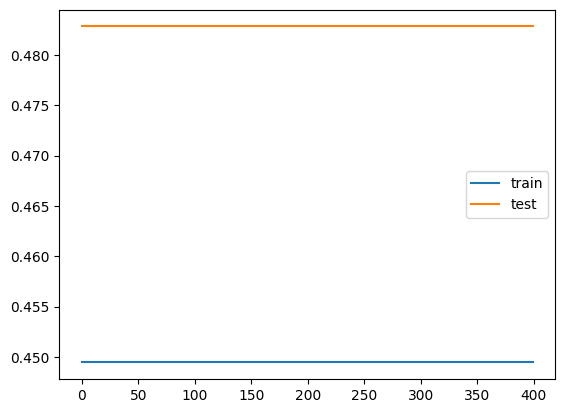

In [57]:
plt.plot(range(num_epochs),train_loss_list,label='train')
plt.plot(range(num_epochs),test_loss_list,label='test')
plt.legend()
plt.show()